# How to generate names with RNNs

This tutorial is available at https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html and it can be seen as a follow up to https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html.

We use a character-level recurrent nn to generate names given a language.

## The data
The data is available at https://download.pytorch.org/tutorial/data.zip. The folder `data/names` contains 18 Unicode text files, one for each of 18 languages, with names such as `[Language].txt`.

With the following code we read the files, convert the data to ASCII and create a dictionary with shape `{language: [name1, name2, ...]}`:

In [1]:
# packages
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

In [2]:
# turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
all_letters = string.ascii_letters + " .,;'-" # our alphabet
n_letters = len(all_letters) + 1 # plus 1 because of EOS marker

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# for example:
print(unicodeToAscii("O'Néàl"))

O'Neal


In [3]:
# read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# get a list of paths for each of the files found with a certain pattern (see below)
def findFiles(path): return glob.glob(path)

# build the category_lines dictionary, a list of lines (i.e. names) per category (i.e. languages)
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)

# categories: 18 ['Greek', 'German', 'Portuguese', 'Irish', 'Scottish', 'Czech', 'English', 'Vietnamese', 'Polish', 'Korean', 'French', 'Spanish', 'Arabic', 'Chinese', 'Dutch', 'Japanese', 'Italian', 'Russian']


## The model

We build a character-level recurrent nn. The input is a pair `<language, name>` where `name` is encoded as a matrix where each row is the tensor corresponding to a letter in the name. The output is a probability distribution over letters (roughly, the probability of the next letter given the previous).

(A picture of the model is available at https://i.imgur.com/jzVrf7f.png.)

The source of recurrence is the fact that a hidden layer computed from the input at a gvien stage (i.e. a letter in the name) is fed to the nn together with the input pair itself at the following stage (i.e. the following letter); moreover, the output at each stage is also fed to the nn as input in the following stage.

In [4]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size) # linear transf. input-to-hidden
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size) # input-to-(intermediate-)output
        self.o2o = nn.Linear(hidden_size + output_size, output_size) #(intermediate-)output-to-(actual-)output
        self.dropout = nn.Dropout(0.1) # the intermediate output is filtered with dropout
        self.softmax = nn.LogSoftmax(dim=1) # then transformed into prob. distribution, the actual output

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1) # input pair and hidden layer are combined here
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## Some useful functions

We define a couple of functions used to extract and process training examples, then we will move to the training of the nn.

In [5]:
import random

# get a random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# get a random category and random line from that category, i.e. one training example
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

For example:

In [6]:
randomTrainingPair()

('Vietnamese', 'Tieu')

In [7]:
# one-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# example
categoryTensor("Italian")

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [8]:
# one-hot matrix of first to last letters (not including EOS) for input name
# i.e., each row is the one-hot tensor of corresponding character in the name
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# example:
inputTensor("max")

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0.]]])

In [9]:
# as the target output: tensor in "long" form, from the second character of the name to EOS tag
# i.e. no zeros, it's a vector of integers representing indexes of characters according to the one-hot encoding
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

# example:
targetTensor("max")

tensor([ 0, 23, 58])

In other words: `m` as input should return `a` (`index=0`) as output; `a` as input should return `x` (`index=23`); `x` as input should return `EOS` (`index=58`) as output

We put it all together:

In [10]:
def randomTrainingExample():
    category, line = randomTrainingPair() # get a random example
    category_tensor = categoryTensor(category) # get the tensor of the language category
    input_line_tensor = inputTensor(line) # get the tensor of the name
    target_line_tensor = targetTensor(line) # get the target tensor
    return category_tensor, input_line_tensor, target_line_tensor

## Training the nn

In [11]:
criterion = nn.NLLLoss() # negative log likelihood
learning_rate = 0.0005

In [12]:
def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)): # loss updated at every step, i.e. for each character
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

In [13]:
# helper function to keep track of the time during training and display it nicely
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [14]:
# the actual training happens here
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 37s (5000 5%) 3.3781
1m 9s (10000 10%) 2.7840
1m 42s (15000 15%) 2.1079
2m 14s (20000 20%) 3.0881
2m 47s (25000 25%) 3.9023
3m 18s (30000 30%) 2.6487
3m 51s (35000 35%) 2.6572
4m 23s (40000 40%) 2.8849
4m 56s (45000 45%) 3.4081
5m 29s (50000 50%) 2.6112
6m 2s (55000 55%) 2.7038
6m 35s (60000 60%) 2.6571
7m 6s (65000 65%) 3.2711
7m 38s (70000 70%) 2.6294
8m 11s (75000 75%) 2.7887
8m 45s (80000 80%) 2.9203
9m 16s (85000 85%) 2.4506
9m 59s (90000 90%) 2.3644
10m 32s (95000 95%) 2.7227
11m 5s (100000 100%) 2.2485


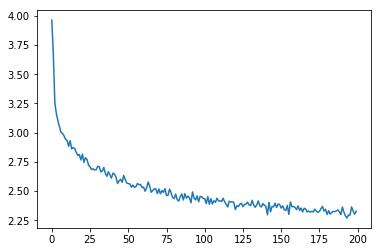

In [15]:
# let's plot the history of loss
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Sampling the nn and generating a name

In order to generate a name, we give the nn a language, a starting letter and a maximum length as input. The current letter and hidden state (initialized as empty) are used to infer the next likely letter, which is written in the output and it becomes the current letter, until `EOS` is inferred or the maximum length is reached.

In [16]:
max_length = 20

# sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

Example:

In [17]:
sample("Italian", "M")

'Marichia'

A little funnier, sample multiple names from multiple starting letters:

In [18]:
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

For example:

In [19]:
samples("Italian", "MNO")

Marichia
Nondin
Orichili


It works! But it could improve... :)